In [1]:
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_classification
from consensusclustering import ConsensusClustering
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', font_scale=1.2)

# Consensus Clustering

The `consensusclustering` package is a Python implementation of the consensus 
clustering algorithm proposed by Monti et al 2003 (https://link.springer
.com/article/10.1023/A:1023949509487) and implemented in R as the 
ConsensusClusterPlus package. In this notebook, we will review how to use the 
`ConsensusClustering` class to replicate an analysis similar to the original paper.

Just for a quick overview, the consensus clustering algorithm finds a consensus over 
multiple runs of a clustering algorithm with random resampling of the data. By 
repeating this with varying numbers of clusters, we can check the stability of 
clustering by comparing consensus matrices and seeing how often items are clustered 
together.

## Data

First, we will create some sample data to show case the package. We will create two 
datasets:
* Uniform random data: This should not cluster well and we should see low stability
* Gaussian random data: This should cluster well and we should see high stability

In [2]:
uniform = np.random.uniform(low=0.0, high=1.0, size=(100, 100))
gaussian = make_classification(
    n_samples=100,
    n_features=100,
    n_informative=100,
    n_redundant=0,
    n_repeated=0,
    n_classes=4,
    n_clusters_per_class=1,
    random_state=42,
    class_sep=10,
)[0]

To get a sense of the datasets lets plot a PCA embedding of each dataset.

In [3]:
pca = PCA(n_components=2, random_state=42)
u_emb = pca.fit_transform(uniform)
g_emb = pca.fit_transform(gaussian)

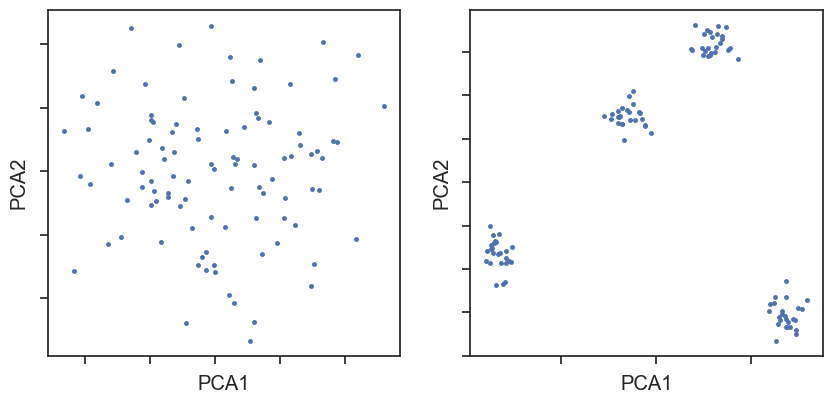

In [4]:
_, axes = plt.subplots(1, 2, figsize=(10, 4.5))
axes[0].plot(u_emb[:, 0], u_emb[:, 1], '.', markersize=5)
axes[1].plot(g_emb[:, 0], g_emb[:, 1], '.', markersize=5)
for ax in axes:
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
plt.show()

## Setting up the consensus clustering

First we setup the clustering object we want to use and vary 'k' for. We then 
construct our `ConsensusClustering` object with the clustering object and specify the
 minimum and maximum number of clusters to search. We also specify the number of 
 resamples and the resample fraction. The number of resamples should be enough to 
 search the space of possible combinations but after a certain point it will have 
 deminisihing returns.

In [5]:
clustering_obj = AgglomerativeClustering(metric='euclidean', linkage='average')

In [6]:
cc = ConsensusClustering(
    clustering_obj=clustering_obj,
    min_clusters=2,
    max_clusters=10,
    n_resamples=1000,
    resample_frac=0.8,
    k_param='n_clusters'
)

## Fitting on the uniform data

Then we call `fit` which will compute the consensus matrix for each number of 
clusters and store the results in an attribute called `consensus_matrices_`

In [7]:
cc.fit(uniform, progress_bar=True)

Computing consensus matrices:   0%|          | 0/9 [00:00<?, ?it/s]

We can now start plotting the results. We can flatten the matrix and plot the CDF of 
the consensus matrix. We expect with stable clustering for most values to be close to
 0 or 1, because this indicates that items are often clustered together across 
 resamples. In the plot below, we see that values in the consensus are distributed 
 between 0 and 1, indicating that the clustering is not stable.

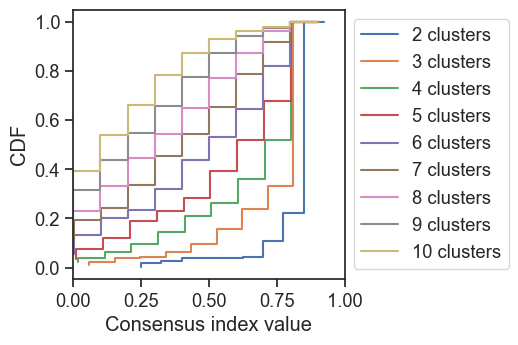

In [8]:
_, ax = plt.subplots(figsize=(3.5, 3.5))
cc.plot_cdf(ax=ax)
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

In the original paper the optimal number of clusters K was chosen by finding K where 
the change in the area under the CDF curve (AUC) was maximised. For unstable 
clustering the CDF will slowly increase and the cut off point is less clear. Through 
experimentation however I have found the change in AUC to be a less optimal method 
compared to finding the knee point of the AUC vs K curve.

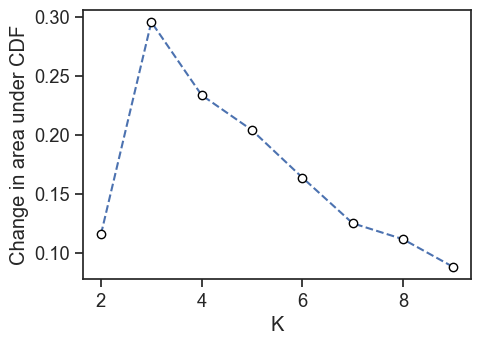

In [9]:
_, ax = plt.subplots(figsize=(5, 3.5))
cc.plot_change_area_under_cdf(ax=ax)
plt.show()

In [10]:
cc.best_k('change_in_auc')

3

Notice how an optimal K seems to be 3 despite instability. Now note the curve 
below showing AUC vs K, it is clear from this plot that the AUC keeps increasing due 
to unstable clustering.

<Axes: xlabel='K', ylabel='Area under CDF'>

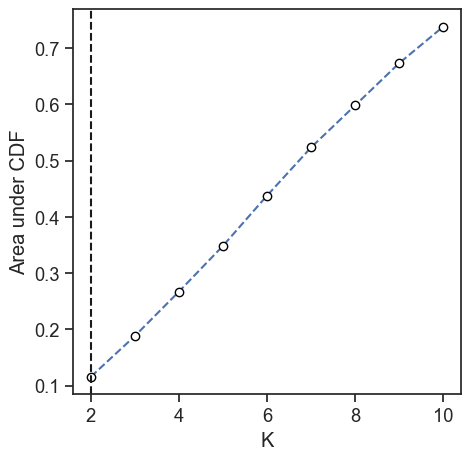

In [11]:
cc.plot_auc_cdf()

When we have a particular K, we can plot the histogram of the consensus matrix and we
 see that the consensus values are distributed between 0 and 1 with the majority of 
 values being 1, indicating a single dominant cluster with smaller unstable clusters.
  Below we show this for K=2 and K=3.

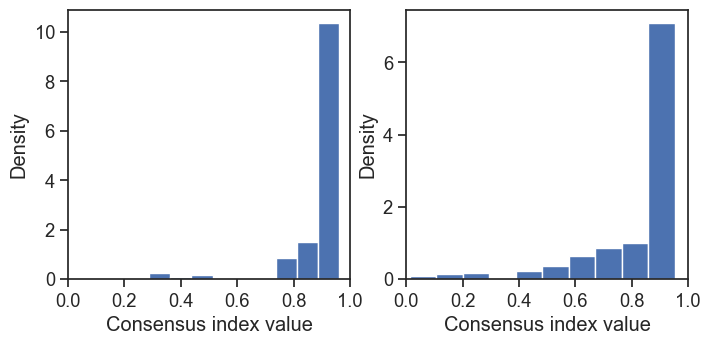

In [12]:
_, axes = plt.subplots(1, 2, figsize=(8, 3.5))
cc.plot_hist(2, ax=axes[0])
cc.plot_hist(3, ax=axes[1])
plt.show()

This is even clearer if we plot a clustered heatmap of the consensus matrix. In 
stable clustering, we should see clear clusters appearing, but below we see random 
assignment.

/Users/malte/Documents/consensusclustering/.venv/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/malte/Documents/consensusclustering/.venv/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


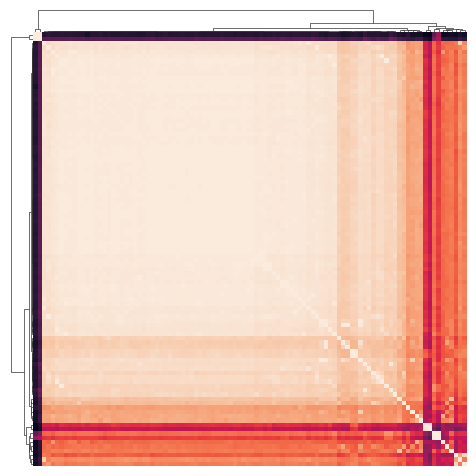

In [13]:
grid = cc.plot_clustermap(
    k=3, 
    figsize=(5, 5), 
    dendrogram_ratio=0.05, 
    xticklabels=False,
    yticklabels=False
)
grid.cax.set_visible(False)

## Fitting on the gaussian data

We will now compare this to the gaussian data with clear class separation.

In [14]:
cc.fit(gaussian, progress_bar=True)

Computing consensus matrices:   0%|          | 0/9 [00:00<?, ?it/s]

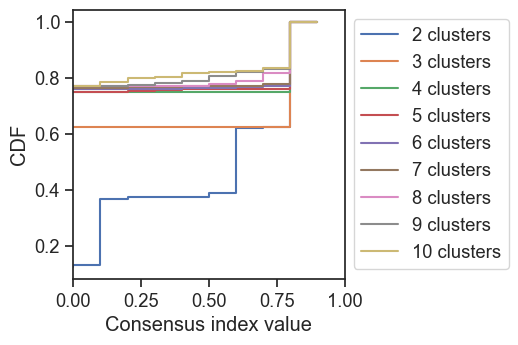

In [15]:
_, ax = plt.subplots(figsize=(3.5, 3.5))
cc.plot_cdf(ax=ax)
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

Notice the rapid change point in the CDF indicating that values sit around 0 and 1.

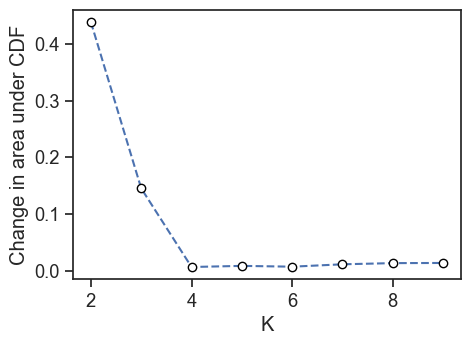

In [16]:
_, ax = plt.subplots(figsize=(5, 3.5))
cc.plot_change_area_under_cdf(ax=ax)
plt.show()

We also see a rapid change in the change in AUC. Here we see the failure of change in
 AUC as a metric for finding the optimal K, with K=2 being the optimal K according to
  this method.

In [17]:
cc.best_k('change_in_auc')

2

Compare this now to the change point in the AUC of the CDF vs K:

<Axes: xlabel='K', ylabel='Area under CDF'>

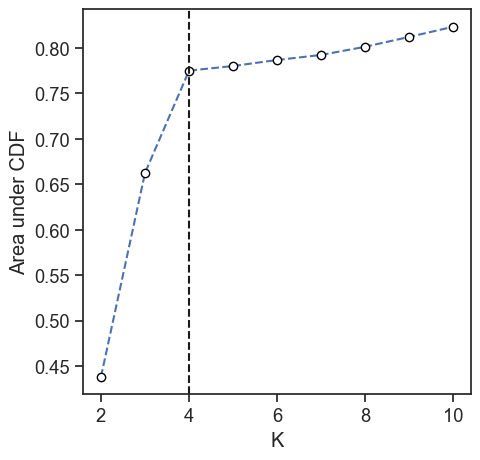

In [18]:
cc.plot_auc_cdf()

In [19]:
cc.best_k('knee')

np.int64(4)

We can make this clearer by plotting the histogram of the consensus matrix for K=2, 
K=3, and K=4

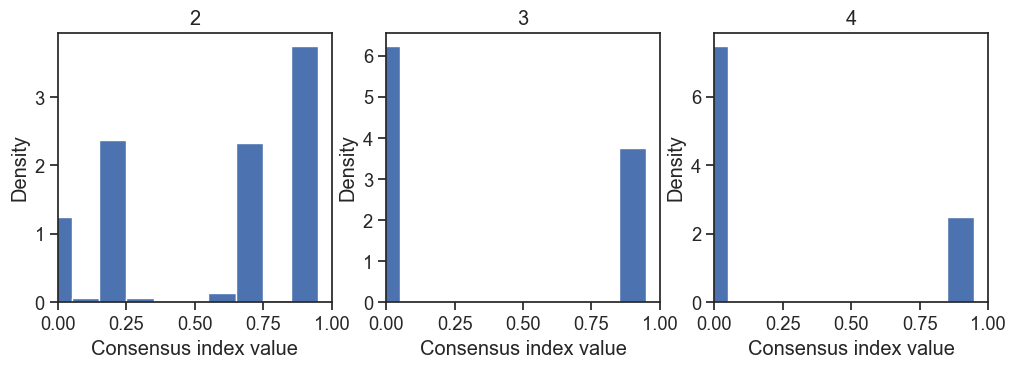

In [20]:
_, axes = plt.subplots(1, 3, figsize=(12, 3.5))
for i, ax in enumerate(axes):
    cc.plot_hist(i + 2, ax=ax)
    ax.set_title(i+2)
plt.show()

We can visualise the optimal K with the clustered heatmap.

/Users/malte/Documents/consensusclustering/.venv/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/malte/Documents/consensusclustering/.venv/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


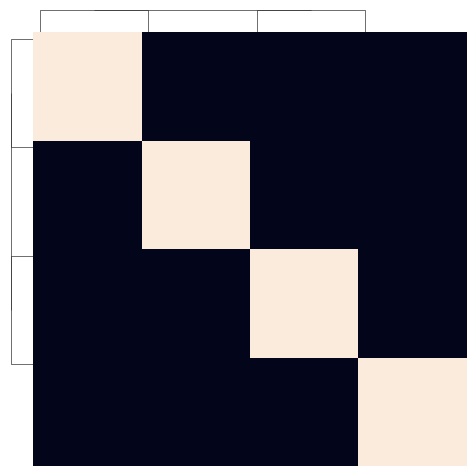

In [21]:
grid = cc.plot_clustermap(
    k=4, 
    figsize=(5, 5), 
    dendrogram_ratio=0.05, 
    xticklabels=False,
    yticklabels=False
)
grid.cax.set_visible(False)